In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller

In [2]:
def generate_datapoints(mu, sigma):
    return np.random.normal(mu, sigma)

#### 1. Dicky-Fuller Test: (Type 0) No Constant, No Trend

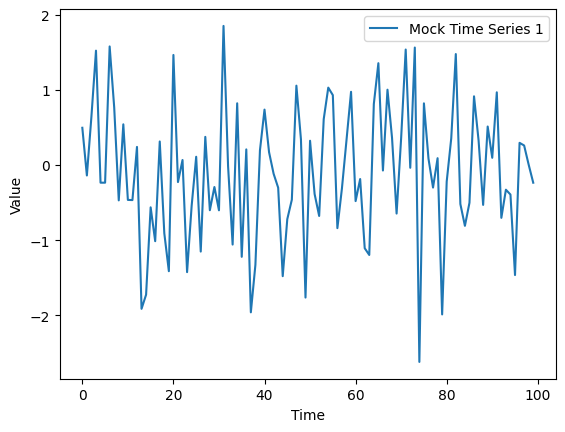

In [3]:
mu = 0
sigma = 1

T = 100

mock1 = pd.Series(index=range(T),
                  dtype='float64')
mock1.name = 'mock time series 1'

np.random.seed(42)
for t in range(T):
    mock1[t] = generate_datapoints(mu=mu,
                                   sigma=sigma)

plt.plot(mock1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series 1'])

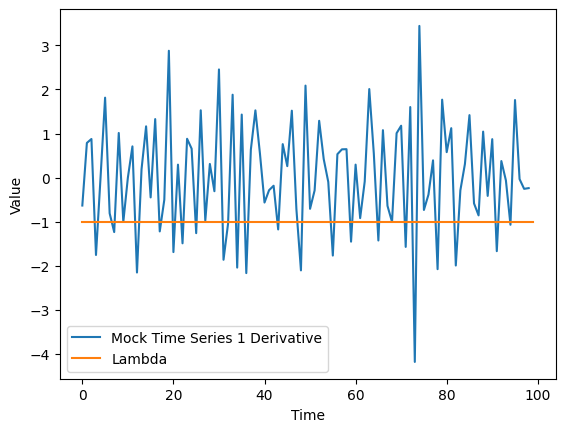

In [4]:
#https://atsa-es.github.io/atsa-labs/sec-boxjenkins-aug-dickey-fuller.html
#https://real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/
derivative = pd.Series(index=range(T - 1),
                       dtype='float64')

for t in range(1, T):
    derivative[t - 1] = mock1[t] - mock1[t - 1]

mock1_copy = mock1.copy().iloc[:-1]

derivative = derivative.to_numpy()
A = mock1_copy.to_numpy()

A_transpose_A = np.dot(A.T, A)
A_transpose_A_inverse = 1 / A_transpose_A

lambda_ = A_transpose_A_inverse * np.dot(A.T, derivative)

lambda_plot = pd.Series(index=range(T - 1),
                        dtype='float64')

for t in range(T):
    lambda_plot[t] = lambda_
    
plt.plot(derivative)
plt.plot(lambda_plot)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series 1 Derivative', 'Lambda'])

In [5]:
num_of_observations = 99
k_parameters = 1

y_predict = lambda_ * A
residuals = derivative - y_predict
sigma_square = np.sum(np.square(residuals)) / (num_of_observations - k_parameters)

var_beta = sigma_square * 1 / np.matmul(A.T, A)
std_error = np.sqrt(var_beta)

t_stat = lambda_ / std_error
t_stat

np.float64(-9.987979313268525)

In [6]:
# verify
adfuller(x=mock1,
         maxlag=0,
         regression="n",
         autolag=None)

(np.float64(-9.987979313268522),
 np.float64(1.0608503289634993e-17),
 0,
 99,
 {'1%': np.float64(-2.5886939026629934),
  '5%': np.float64(-1.9440242848853808),
  '10%': np.float64(-1.6143879418406077)})

#### 2. Dicky-Fuller Test: (Type 2) Constant & Trend

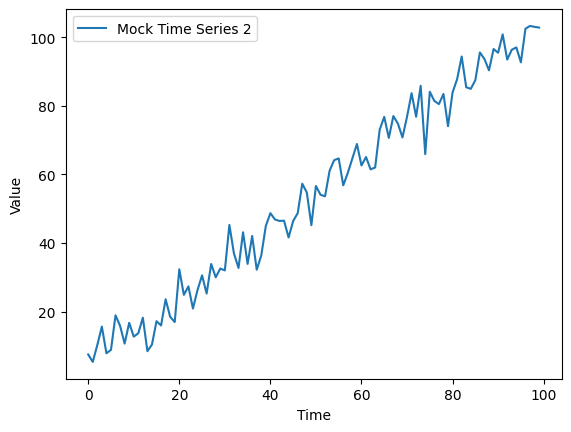

In [7]:
sigma = 5

T = 100

mock2 = pd.Series(index=range(T),
                  dtype='float64')
mock2.name = 'mock time series 2'

np.random.seed(42)
for t in range(T):
    mock2[t] = generate_datapoints(mu=t,
                                   sigma=sigma) + 5

plt.plot(mock2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series 2'])

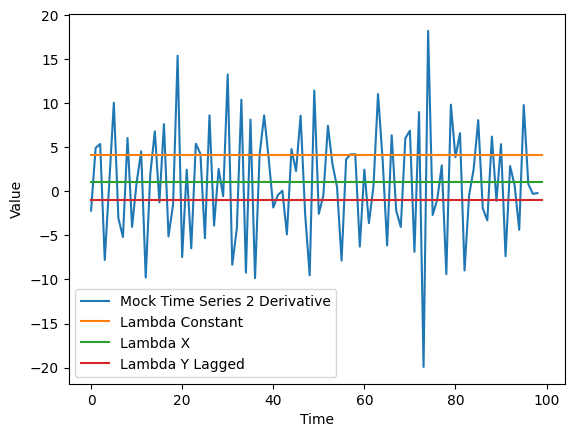

In [8]:
derivative = pd.Series(index=range(T - 1),
                       dtype='float64')

for t in range(1, T):
    derivative[t - 1] = mock2[t] - mock2[t - 1]

mock2_copy = mock2.copy().iloc[:-1]

derivative = derivative.to_numpy()
x = np.array([i for i in range(1, 100)])
y_lagged = mock2_copy.to_numpy()
constant = np.ones(y_lagged.shape)

A = np.vstack((constant, x, y_lagged)).T
A_transpose_A = np.matmul(A.T, A)
A_transpose_A_inverse =  np.linalg.inv(A_transpose_A)

lambdas = np.matmul(np.matmul(A_transpose_A_inverse, A.T), derivative)

lambda_plot_constant = pd.Series(index=range(T - 1),
                                 dtype='float64')
lambda_plot_x = pd.Series(index=range(T - 1),
                          dtype='float64')
lambda_plot_y_lagged = pd.Series(index=range(T - 1),
                                 dtype='float64')

for t in range(T):
    lambda_plot_constant[t] = lambdas[0]
    lambda_plot_x[t] = lambdas[1]
    lambda_plot_y_lagged[t] = lambdas[2]
    
plt.plot(derivative)
plt.plot(lambda_plot_constant)
plt.plot(lambda_plot_x)
plt.plot(lambda_plot_y_lagged)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series 2 Derivative', 'Lambda Constant', 'Lambda X', 'Lambda Y Lagged'])

In [9]:
num_of_observations = 99
k_parameters = 3

y_predict = np.matmul(A, lambdas)
residuals = derivative - y_predict
sigma_square = np.sum(np.square(residuals)) / (num_of_observations - k_parameters)

var_beta = sigma_square * np.linalg.inv(np.matmul(A.T, A))
std_errors = np.sqrt(np.diag(var_beta))

t_stat = lambdas / std_errors
t_stat

array([  4.1470423 ,   9.95648258, -10.06505569])

In [10]:
# verify
adfuller(x=mock2,
         maxlag=0,
         regression="ct",
         autolag=None)

(np.float64(-10.065055689139946),
 np.float64(1.681169154381127e-15),
 0,
 99,
 {'1%': np.float64(-4.053254236405479),
  '5%': np.float64(-3.455806184392646),
  '10%': np.float64(-3.1535907061122397)})

#### 2. Augmented Dicky-Fuller Test: (Type 2) Constant & Trend

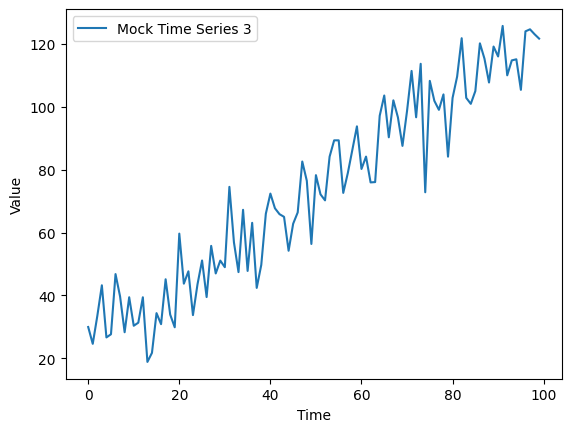

In [11]:
sigma = 10

T = 100

mock3 = pd.Series(index=range(T),
                  dtype='float64')
mock3.name = 'mock time series 3'

np.random.seed(42)
for t in range(T):
    mock3[t] = generate_datapoints(mu=t,
                                   sigma=sigma) + 25

plt.plot(mock3)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series 3'])

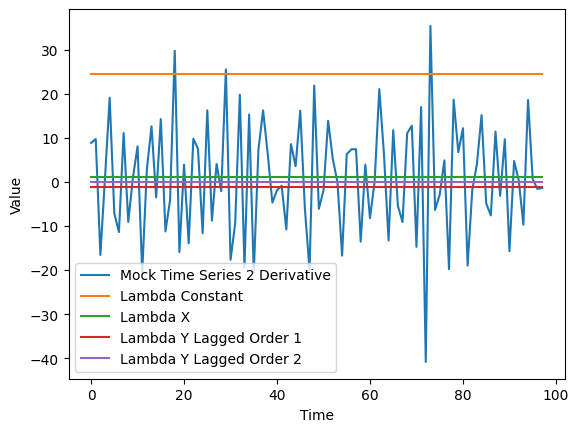

In [12]:
# https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
# For this example just using p (lag order) = 1
derivative = pd.Series(index=range(T - 2),
                       dtype='float64')
for t in range(2, T):
    derivative[t - 2] = mock3[t] - mock3[t - 1]
derivative = derivative.to_numpy()


constant = np.ones(98)
x = np.array([i for i in range(2, 100)])
y_lagged_original = mock3.copy().iloc[1:-1].to_numpy()

y_lagged_order_1 = np.zeros(98)
for t in range(2, T):
    y_lagged_order_1[t - 2] = mock3[t - 1] - mock3[t - 2]


A = np.vstack((constant, x, y_lagged_original, y_lagged_order_1)).T
A_transpose_A = np.matmul(A.T, A)
A_transpose_A_inverse = np.linalg.inv(A_transpose_A)


lambdas = np.matmul(np.matmul(A_transpose_A_inverse, A.T), derivative)

lambda_plot_constant = pd.Series(index=range(T - 2),
                                 dtype='float64')
lambda_plot_x = pd.Series(index=range(T - 2),
                          dtype='float64')
lambda_plot_y_lagged_original = pd.Series(index=range(T - 2),
                                          dtype='float64')
lambda_plot_y_lagged_order_1 = pd.Series(index=range(T - 2),
                                       dtype='float64')


for t in range(T - 2):
    lambda_plot_constant[t] = lambdas[0]
    lambda_plot_x[t] = lambdas[1]
    lambda_plot_y_lagged_original[t] = lambdas[2]
    lambda_plot_y_lagged_order_1[t] = lambdas[3]
    
plt.plot(derivative)
plt.plot(lambda_plot_constant)
plt.plot(lambda_plot_x)
plt.plot(lambda_plot_y_lagged_original)
plt.plot(lambda_plot_y_lagged_order_1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series 2 Derivative', 'Lambda Constant', 'Lambda X', 'Lambda Y Lagged Order 1', 'Lambda Y Lagged Order 2'])

In [13]:
num_of_observations = 98
k_parameters = 4

y_predict = np.matmul(A, lambdas)
residuals = derivative - y_predict
sigma_square = np.sum(np.square(residuals)) / (num_of_observations - k_parameters)

var_beta = sigma_square * np.linalg.inv(np.matmul(A.T, A))
std_errors = np.sqrt(np.diag(var_beta))

t_stat = lambdas / std_errors
t_stat

array([ 6.59567241,  7.10143498, -7.26462948,  0.42902194])

In [14]:
# verify
adfuller(x=mock3,
         maxlag=1,
         regression="ct",
         autolag=None)

(np.float64(-7.2646294802048725),
 np.float64(3.5329223624326323e-09),
 1,
 98,
 {'1%': np.float64(-4.054251125423931),
  '5%': np.float64(-3.4562790670553936),
  '10%': np.float64(-3.153866135708761)})